<style>
div.output_scroll {
    height: auto !important;
    max-height: none !important;
}
</style>

# Modélisation

Seuls les véhicules de l'année 2023 et de la France ont été exportés à partir de https://www.eea.europa.eu/data-and-maps/data/co2-cars-emission-20

# <font color='#3585CD'>Importation des librairies</font>

In [17]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, Lasso, Ridge

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor

from sklearn.model_selection import learning_curve

import time

import joblib

# <font color='#3585CD'>Chargement des données</font>

## Chargement du dataset nettoyé

In [18]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [19]:
dossier_fichiers = "/content/drive/My Drive/Formation DS/Projet CO2/Donnees_UE/datasets/Dataset_final/"
dossier_modeles = "/content/drive/My Drive/Formation DS/Projet CO2/Donnees_UE/models/"


In [20]:
dataset_path = dossier_fichiers + "datas_nettoyees_model_FR.csv"
df = pd.read_csv(dataset_path)
df.head(10)


Marque              Modèle  Masse à vide  CO2 Carburant  Cylindrée moteur  \
0   JEEP            RENEGADE        1845.0   49   hybride            1332.0   
1   JEEP            WRANGLER        1883.0  244   essence            1995.0   
2   JEEP            WRANGLER        1972.0  259   essence            1995.0   
3   JEEP            WRANGLER        1972.0  258   essence            1995.0   
4   JEEP  WRANGLER UNLIMITED        2348.0   79   hybride            1995.0   
5   JEEP  WRANGLER UNLIMITED        2409.0   94   hybride            1995.0   
6  HONDA                HR-V        1452.0  122   essence            1498.0   
7   JEEP            RENEGADE        1395.0  145   essence             999.0   
8   JEEP            RENEGADE        1395.0  146   essence             999.0   
9   JEEP            RENEGADE        1395.0  149   essence            1332.0   

   Puissance moteur  Consommation carburant  
0              96.0                     2.0  
1             200.0                    10.8  
2             200.0                    11.5  
3             200.0                    11.5  
4             200.0                     3.5  
5             200.0                     4.1  
6              79.0                     5.4  
7              88.0                     6.4  
8              88.0                     6.4  
9             110.0                     6.6

# <font color='#3585CD'>Fonctions qui seront utilisées dans ce notebook</font>

In [21]:
def afficher_courbes_apprentissage(model, nom_modele):
    train_sizes, train_scores, val_scores = learning_curve(
    model, X, y, cv=5, scoring="neg_mean_absolute_error", train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
    # Moyenne et écart-type des scores
    train_mean = -np.mean(train_scores, axis=1)  # On remet en positif (MAE est négatif)
    train_std = np.std(train_scores, axis=1)
    val_mean = -np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Tracer les courbes
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Erreur d'entraînement")
    plt.plot(train_sizes, val_mean, 'o-', color="red", label="Erreur de validation")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="red")

    plt.xlabel("Nombre d'exemples d'entraînement")
    plt.ylabel("Erreur Absolue Moyenne (MAE)")
    plt.title("Courbe d'Apprentissage")
    plt.legend()
    plt.show()

def affichage_erreurs(y_test, y_pred, modele):
    # Calcul des résidus
    residuals = y_test - y_pred
    # Création d'une figure avec deux sous-graphiques côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Graphique des résidus (Scatterplot)
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, ax=axes[0])
    axes[0].axhline(y=0, color="red", linestyle="--")
    axes[0].set_xlabel("Valeurs prédites")
    axes[0].set_ylabel("Résidus")
    axes[0].set_title(f"Graphique des résidus modèle {modele}")
    axes[0].grid()

    # Histogramme des erreurs
    sns.histplot(residuals, bins=30, kde=True, ax=axes[1])
    axes[1].axvline(x=0, color="red", linestyle="--")
    axes[1].set_xlabel("Erreur (résidu)")
    axes[1].set_ylabel("Fréquence")
    axes[1].set_title(f"Histogramme des erreurs {modele}")
    axes[1].grid()

    # Affichage
    plt.tight_layout()
    plt.show()

def affichage_valeurs_reelles_vs_predites(y_test, y_pred, modele):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Valeurs prédites")
    plt.title(f"Réelles vs Prédites {modele}")
    plt.grid()
    plt.show()

def affichage_QQ_plot_residus(y_test, y_pred, modele):
    residuals = y_test - y_pred
    # Configuration du style Seaborn
    sns.set(style="whitegrid")

    # Création du QQ-plot
    fig, ax = plt.subplots(figsize=(8, 5))
    stats.probplot(residuals, dist="norm", plot=ax)

    # Ajout du titre
    ax.set_title(f"QQ-Plot des résidus {modele}")

    # Affichage du graphique
    plt.show()

import plotly.graph_objects as go
from sklearn.model_selection import learning_curve
import numpy as np

def afficher_courbes_apprentissage_plotly(model, nom_modele, cv=3, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, scoring="neg_mean_absolute_error",
        train_sizes=train_sizes, n_jobs=-1
    )

    train_mean = -np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = -np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    fig = go.Figure()

    # Courbe d'entraînement
    fig.add_trace(go.Scatter(
        x=train_sizes, y=train_mean,
        mode='lines+markers',
        name="Erreur d'entraînement",
        line=dict(color='blue'),
    ))

    # # Bande d'écart-type entraînement
    # fig.add_trace(go.Scatter(
    #     x=np.concatenate([train_sizes, train_sizes[::-1]]),
    #     y=np.concatenate([train_mean - train_std, (train_mean + train_std)[::-1]]),
    #     fill='toself',
    #     fillcolor='rgba(0, 0, 255, 0.1)',
    #     line=dict(color='rgba(255,255,255,0)'),
    #     hoverinfo="skip",
    #     showlegend=False
    # ))

    # Courbe de validation
    fig.add_trace(go.Scatter(
        x=train_sizes, y=val_mean,
        mode='lines+markers',
        name="Erreur de validation",
        line=dict(color='red'),
    ))

    # # Bande d'écart-type validation
    # fig.add_trace(go.Scatter(
    #     x=np.concatenate([train_sizes, train_sizes[::-1]]),
    #     y=np.concatenate([val_mean - val_std, (val_mean + val_std)[::-1]]),
    #     fill='toself',
    #     fillcolor='rgba(255, 0, 0, 0.1)',
    #     line=dict(color='rgba(255,255,255,0)'),
    #     hoverinfo="skip",
    #     showlegend=False
    # ))

    fig.update_layout(
        title=f"Courbe d'Apprentissage - {nom_modele}",
        xaxis_title="Nombre d'exemples d'entraînement",
        yaxis_title="Erreur Absolue Moyenne (MAE)",
        legend=dict(
            x=1.05,
            y=1,
            xanchor='left',
            yanchor='top'
        ),
        template="plotly_white"
    )

    fig.show()

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import numpy as np
import pandas as pd

def affichage_erreurs_plotly(y_test, y_pred, modele):
    residuals = y_test - y_pred

    # Création d'une figure avec deux sous-graphiques
    fig = make_subplots(rows=1, cols=2, subplot_titles=(
        f"Graphique des résidus modèle {modele}",
        f"Histogramme des erreurs {modele}"
    ))

    # Scatterplot des résidus
    fig.add_trace(
        go.Scatter(
            x=y_pred,
            y=residuals,
            mode='markers',
            marker=dict(opacity=0.5),
            name="Résidus"
        ),
        row=1, col=1
    )
    fig.add_hline(y=0, line=dict(color="red", dash="dash"), row=1, col=1)

    # Histogramme des résidus
    fig.add_trace(
        go.Histogram(
            x=residuals,
            nbinsx=30,
            name="Erreurs",
            marker=dict(color="blue"),
            opacity=0.7
        ),
        row=1, col=2
    )
    fig.add_vline(x=0, line=dict(color="red", dash="dash"), row=1, col=2)

    fig.update_layout(
        title_text=f"Analyse des erreurs - {modele}",
        width=1000,
        height=400,
        showlegend=False
    )
    fig.update_xaxes(title_text="Valeurs prédites", row=1, col=1)
    fig.update_yaxes(title_text="Résidus", row=1, col=1)
    fig.update_xaxes(title_text="Erreur (résidu)", row=1, col=2)
    fig.update_yaxes(title_text="Fréquence", row=1, col=2)

    fig.show()


def affichage_valeurs_reelles_vs_predites_plotly(y_test, y_pred, modele):
    df = pd.DataFrame({"Réelles": y_test, "Prédites": y_pred})

    fig = px.scatter(
        df,
        x="Réelles",
        y="Prédites",
        opacity=0.5,
        title=f"Valeurs Réelles vs Prédites - {modele}",
        labels={"Réelles": "Valeurs réelles", "Prédites": "Valeurs prédites"}
    )

    # Ajout de la ligne d'identité
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    fig.add_trace(
        go.Scatter(
            x=[min_val, max_val],
            y=[min_val, max_val],
            mode="lines",
            line=dict(color="red", dash="dash"),
            name="Ligne idéale"
        )
    )

    fig.update_layout(
        width=1000,
        height=600,
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True)
    )

    fig.show()

import plotly.graph_objects as go

def affichage_residus_plotly(y_test, y_pred, modele):
    residuals = y_test - y_pred

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=y_pred,
            y=residuals,
            mode='markers',
            marker=dict(opacity=0.5),
            name="Résidus"
        )
    )

    fig.add_hline(y=0, line=dict(color="red", dash="dash"))

    fig.update_layout(
        title=f"Graphique des résidus - {modele}",
        xaxis_title="Valeurs prédites",
        yaxis_title="Résidus",
        width=600,
        height=400,
        showlegend=False,
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True)
    )

    fig.show()

import plotly.graph_objects as go

def affichage_residus_plotly(y_test, y_pred, modele):
    residuals = y_test - y_pred

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=y_pred,
            y=residuals,
            mode='markers',
            marker=dict(opacity=0.5),
            name="Résidus"
        )
    )

    fig.add_hline(y=0, line=dict(color="red", dash="dash"))

    fig.update_layout(
        title=f"Graphique des résidus - {modele}",
        xaxis_title="Valeurs prédites",
        yaxis_title="Résidus",
        width=1000,
        height=600,
        showlegend=False,
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True)
    )

    fig.show()

import numpy as np
from scipy.stats import gaussian_kde
import plotly.graph_objects as go

def affichage_histogramme_erreurs_plotly(y_test, y_pred, modele):
    residuals = y_test - y_pred

    # Calcul de la densité KDE
    kde = gaussian_kde(residuals)
    x_kde = np.linspace(residuals.min(), residuals.max(), 500)
    y_kde = kde(x_kde)

    fig = go.Figure()

    # Histogramme des résidus
    fig.add_trace(
        go.Histogram(
            x=residuals,
            nbinsx=30,
            marker=dict(color="blue"),
            opacity=0.6,
            name="Erreurs",
            histnorm='probability density'
        )
    )

    # Courbe KDE
    fig.add_trace(
        go.Scatter(
            x=x_kde,
            y=y_kde,
            mode="lines",
            line=dict(color="orange", width=2),
            name="Densité KDE"
        )
    )

    # Ligne verticale à 0
    fig.add_vline(x=0, line=dict(color="red", dash="dash"))

    fig.update_layout(
        title=f"Histogramme des erreurs avec KDE - {modele}",
        xaxis_title="Erreur (résidu)",
        yaxis_title="Densité de probabilité",
        width=1000,
        height=600,
        showlegend=True,
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True)
    )

    fig.show()

import numpy as np
from scipy.stats import gaussian_kde
import plotly.graph_objects as go

import numpy as np
from scipy.stats import gaussian_kde
import plotly.graph_objects as go

def affichage_histogramme_erreurs_plotly(y_test, y_pred, modele):
    residuals = y_test - y_pred

    # Calcul de la densité KDE
    kde = gaussian_kde(residuals)
    x_kde = np.linspace(residuals.min(), residuals.max(), 500)
    y_kde = kde(x_kde)

    fig = go.Figure()

    # Histogramme des résidus avec bordure discrète et alpha
    fig.add_trace(
        go.Histogram(
            x=residuals,
            nbinsx=50,
            marker=dict(
                color="blue",
                line=dict(color="lightgray", width=1)  # Bordure discrète
            ),
            opacity=0.5,  # Transparence douce
            name="Histogramme des erreurs",
            histnorm='probability density'
        )
    )

    # Courbe KDE
    fig.add_trace(
        go.Scatter(
            x=x_kde,
            y=y_kde,
            mode="lines",
            line=dict(color="orange", width=2),
            name="Courbe KDE"
        )
    )

    # Ligne verticale à 0
    fig.add_vline(x=0, line=dict(color="red", dash="dash"))

    fig.update_layout(
        title=f"Histogramme des erreurs avec KDE - {modele}",
        xaxis_title="Erreur (résidu)",
        yaxis_title="Densité de probabilité",
        width=1000,
        height=600,
        showlegend=True,
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True)
    )

    fig.show()

def plot_correlation_matrix(df):
  """
  Affiche la matrice de corrélation des variables numériques sous forme de heatmap interactive avec Plotly.

  :param df: DataFrame Pandas contenant les données
  """
  # Sélection des colonnes numériques
  num_numeric_cols = df.select_dtypes(include=['number']).columns

  # Calcul de la matrice de corrélation
  corr_matrix = df[num_numeric_cols].corr()

  # Création de la heatmap avec Plotly (labels en bas et à gauche)
  fig = ff.create_annotated_heatmap(
      z=corr_matrix.values,
      x=list(corr_matrix.columns),
      y=list(corr_matrix.index),
      colorscale="RdBu_r",
      annotation_text=corr_matrix.round(2).values,
      showscale=True
  )

  # Ajustement de la disposition
  fig.update_layout(
      title="Matrice de corrélation des variables numériques",
      height=600, width=800,
      xaxis=dict(side="bottom", tickangle=-45),
      yaxis=dict(side="left")
  )

  # Affichage
  fig.show()

# <font color='#3585CD'>Premières analyses</font>

## Informations sur le dataset

In [22]:
print("\nAperçu du dataset :")
print(df.info())


Aperçu du dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23935 entries, 0 to 23934
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Marque                  23935 non-null  object 
 1   Modèle                  23935 non-null  object 
 2   Masse à vide            23935 non-null  float64
 3   CO2                     23935 non-null  int64  
 4   Carburant               23935 non-null  object 
 5   Cylindrée moteur        23935 non-null  float64
 6   Puissance moteur        23935 non-null  float64
 7   Consommation carburant  23935 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 1.5+ MB
None


## Satistiques descriptives

In [23]:
print("\nStatistiques descriptives :")
display(df.describe(include='all').T)


Statistiques descriptives :


count unique      top   freq         mean  \
Marque                    23935     57      BMW   3645          NaN   
Modèle                    23935   1066  OCTAVIA    546          NaN   
Masse à vide            23935.0    NaN      NaN    NaN  1647.538095   
CO2                     23935.0    NaN      NaN    NaN   140.723376   
Carburant                 23935      5  essence  11445          NaN   
Cylindrée moteur        23935.0    NaN      NaN    NaN  1821.354878   
Puissance moteur        23935.0    NaN      NaN    NaN   132.922122   
Consommation carburant  23935.0    NaN      NaN    NaN     5.852659   

                               std    min     25%     50%     75%     max  
Marque                         NaN    NaN     NaN     NaN     NaN     NaN  
Modèle                         NaN    NaN     NaN     NaN     NaN     NaN  
Masse à vide            330.491688  570.0  1420.0  1595.0  1820.0  2866.0  
CO2                      48.452714   10.0   126.0   140.0   158.0   572.0  
Carburant                      NaN    NaN     NaN     NaN     NaN     NaN  
Cylindrée moteur        649.703515  658.0  1469.0  1950.0  1995.0  7993.0  
Puissance moteur         68.629921   44.0    96.0   110.0   145.0  1177.0  
Consommation carburant    2.045241    0.4     5.2     5.8     6.7    25.2

# <font color='#3585CD'>Visualisation globale graphique</font>

In [24]:
fig = px.scatter_matrix(df, dimensions=df.select_dtypes(include=['number']).columns,
                        color='Carburant', title="Pairplot")

fig.update_layout(height=900, width=1200)
fig.show()

In [25]:
plot_correlation_matrix(df)

# Sélection des données : variable cible et variables explicatives

In [26]:
df_copy = df.copy()
X = df_copy.drop(columns=['CO2', 'Marque', 'Modèle', 'Consommation carburant'], axis=1)
y = df_copy['CO2']

# Pré-processeur

In [27]:
# Colonnes à transformer
# Colonnes catégorielles
categorical_features = ['Carburant']
# Colonnes numériques
numeric_features = X.drop(columns=categorical_features).columns.tolist()

# Préprocesseur pour le pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Séparation des données

In [28]:
# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19148 entries, 1527 to 12706
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Masse à vide      19148 non-null  float64
 1   Carburant         19148 non-null  object 
 2   Cylindrée moteur  19148 non-null  float64
 3   Puissance moteur  19148 non-null  float64
dtypes: float64(3), object(1)
memory usage: 748.0+ KB


In [30]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4787 entries, 8317 to 22778
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Masse à vide      4787 non-null   float64
 1   Carburant         4787 non-null   object 
 2   Cylindrée moteur  4787 non-null   float64
 3   Puissance moteur  4787 non-null   float64
dtypes: float64(3), object(1)
memory usage: 187.0+ KB


# Fonction utilisée pour entrainer et optimiser un modèle

In [31]:
import time

def entrainer_et_optimiser_model(model, param_grid, model_name, cv=5, method='GridSearchCV', save_model=True):
    """
    Fonction qui entraîne et optimise un modèle de régression avec GridSearchCV,
    retourne les performances et le temps d'exécution.
    """

    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', model)
    ])

    scoring = {
        'r2': 'r2',
        'neg_mean_absolute_error': 'neg_mean_absolute_error'
    }
    if method == 'GridSearchCV':
      search = GridSearchCV(
          estimator=pipeline,
          param_grid=param_grid,
          scoring=scoring,
          refit='r2',
          cv=cv,
          n_jobs=-1,
          verbose=2
      )
    else:
      search = RandomizedSearchCV(
          estimator=pipeline,
          param_distributions=param_grid,
          scoring=scoring,
          refit='r2',
          cv=cv,
          n_jobs=-1,
          n_iter=5,
          verbose=2
      )

    # Début du chrono
    start_time = time.time()

    # Entraînement
    search.fit(X_train, y_train)

    # Fin du chrono
    end_time = time.time()
    execution_time = end_time - start_time

    best_params = search.best_params_
    best_model = search.best_estimator_

    mae_cv = -search.cv_results_['mean_test_neg_mean_absolute_error'].mean()

    y_pred_train = best_model.predict(X_train)
    r2_train = r2_score(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

    y_pred_test = best_model.predict(X_test)
    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    overfitting_ratio = r2_train - r2_test
    underfitting_flag = r2_train < 0.80

    # Sauvegarde du modèle
    if save_model:
        chemin_fichier = dossier_modeles + f"{model_name}_model.pkl"
        joblib.dump(best_model, chemin_fichier)
        print(f"Le meilleur modèle a été sauvegardé sous le nom : {model_name}_model.pkl")

    print(f"Meilleurs hyperparamètres : {best_params}")
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    results = pd.DataFrame([{
        'Modèle': model_name,
        'R² moyen (CV)': search.best_score_,
        'MAE moyen (CV)': mae_cv,
        'RMSE train': rmse_train,
        'MAE train': mae_train,
        'R2 train': r2_train,
        'RMSE test': rmse_test,
        'MAE test': mae_test,
        'R2 test': r2_test,
        'Ecart RMSE / MAE test' : rmse_test - mae_test,
        'Ratio overfitting': overfitting_ratio,
        'Alerte Underfitting': underfitting_flag,
        'Temps d\'exécution (s)': execution_time
    }])

    return best_model, best_params, y_pred_test, results


# Modèle LinearRegression

## Entrainement et optimisation

In [32]:
# Grille des hyperparamètres à tester
param_grid_lr = {
    'regressor__fit_intercept': [True, False]
}

best_model_lr, best_params_lr, predictions_lr, resultats_lr = entrainer_et_optimiser_model(LinearRegression(), param_grid_lr, 'LinearRegression')
resultats_lr

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Le meilleur modèle a été sauvegardé sous le nom : LinearRegression_model.pkl
Meilleurs hyperparamètres : {'regressor__fit_intercept': True}
Temps d'exécution : 3.10 secondes


Modèle  R² moyen (CV)  MAE moyen (CV)  RMSE train  MAE train  \
0  LinearRegression       0.861633       12.755799   18.092005  12.746382   

   R2 train  RMSE test   MAE test   R2 test  Ecart RMSE / MAE test  \
0  0.861944  18.333669  13.053282  0.850873               5.280387   

   Ratio overfitting  Alerte Underfitting  Temps d'exécution (s)  
0           0.011071                False               3.104545

### Comment détecter un surapprentissage ?


Comparer RMSE / MAE entre train et test.

Observer l’écart entre R² train et R² test :

Si R² train ≈ R² test ➡️ OK.

Si R² train très haut et R² test plus bas ➡️ ⚠️ Surapprentissage.

Calculer un ratio d’overfitting *r2_train - r2_test* : Plus ce ratio est élevé, plus il y a un risque de surapprentissage.

### Comment détecter le sous-apprentissage ?

R² faible sur le train (< 0.80)

RMSE / MAE élevés sur le train

Si R² train ≈ R² test, mais les deux sont bas

## Recharger un modèle

Pour recharger le modèle il suffira de :



```
# Charger le modèle enregistré
loaded_model = joblib.load('linear_regression_model.pkl')

# Prédire avec le modèle chargé
y_pred = loaded_model.predict(X_test)
```




## Comparaison des valeurs réelles et prédites

In [33]:
pd.DataFrame({'Valeurs réelles': y_test.values.ravel(), 'Valeurs predict': predictions_lr}).head(10)

Valeurs réelles  Valeurs predict
0              182       200.487916
1              151       145.711837
2              171       153.177143
3              123       127.664709
4              133       127.134355
5              148       145.955084
6              134       127.968461
7              136       139.251893
8              133       145.603829
9              123       135.445338

In [34]:
affichage_valeurs_reelles_vs_predites_plotly(y_test, predictions_lr, 'LinearRegression')

## Courbe d'apprentissage

### Objectif

La courbe d'apprentissage permet de vérifier si le modèle apprend bien avec plus de données.
<br/><p><b>Rappel :</b> </p>
<p><b>1. Courbe idéale (Bonne généralisation)</b></p>
<P>L’erreur d’entraînement diminue progressivement.</P>
<P>L’erreur de validation suit une trajectoire similaire.</P>
<P>Les deux erreurs se stabilisent à des valeurs proches.</P>
<p><b>2. Surajustement (Overfitting)</b></p>
<P>L’erreur d’entraînement est très faible (voire 0).</P>
<P>L’erreur de validation est élevée et ne diminue pas.</P>
<P>Le modèle a appris "par cœur" et ne généralise pas bien.</P>
<p><b>3. Sous-ajustement (Underfitting)</b></p>
<P>L’erreur d’entraînement et de validation restent élevées.</P>
<P>Le modèle est trop simple et n’arrive pas à capturer la relation entre X et y.</P>
<ul>
    <li>Si l'erreur de test est très supérieure à l'erreur d'entraînement → Sur-apprentissage.</li>
<li>Si l'erreur est élevée sur les deux courbes → Sous-apprentissage.</li>
</ul>

### Courbe

In [35]:
afficher_courbes_apprentissage_plotly(best_model_lr, 'LinearRegression')

Modèle bien généralisant :

Pas de gros écart entre l’erreur d'entraînement et de validation.
Pas de signe fort de surapprentissage (les deux erreurs restent proches).

➤ Sous-apprentissage léger :
Vu que l'erreur de validation ne baisse pas malgré plus de données, le modèle atteint probablement ses limites de complexité.

Typique des modèles linéaires : ils ne peuvent capturer que des relations linéaires, donc si le problème est un peu plus complexe, il plafonne.

## Affichage des erreurs de prédictions

### Objectif

La **courbe des résidus** permet de vérifier si les erreurs sont aléatoires ou s'il y a une tendance dans les erreurs du modèle.
<ul>
    <li>Bonne prédiction : les points doivent être répartis aléatoirement autour de 0.
</li>
<li>Mauvaise prédiction : structure visible (courbe, tendance…).</li>
</ul>

**L'histogramme des erreurs** permet de vérifier si les erreurs suivent une distribution normale.
<ul>
    <li>Bonne prédiction : la distribution est centrée sur 0 (forme de courbe en cloche).
</li>
<li>Mauvaise prédiction : la distribution asymétrique ou biaisée.</li>
</ul>

### Graphiques

In [36]:
affichage_residus_plotly(y_test, predictions_lr, 'LinearRegression')

In [37]:
affichage_histogramme_erreurs_plotly(y_test, predictions_lr, 'LinearRegression')

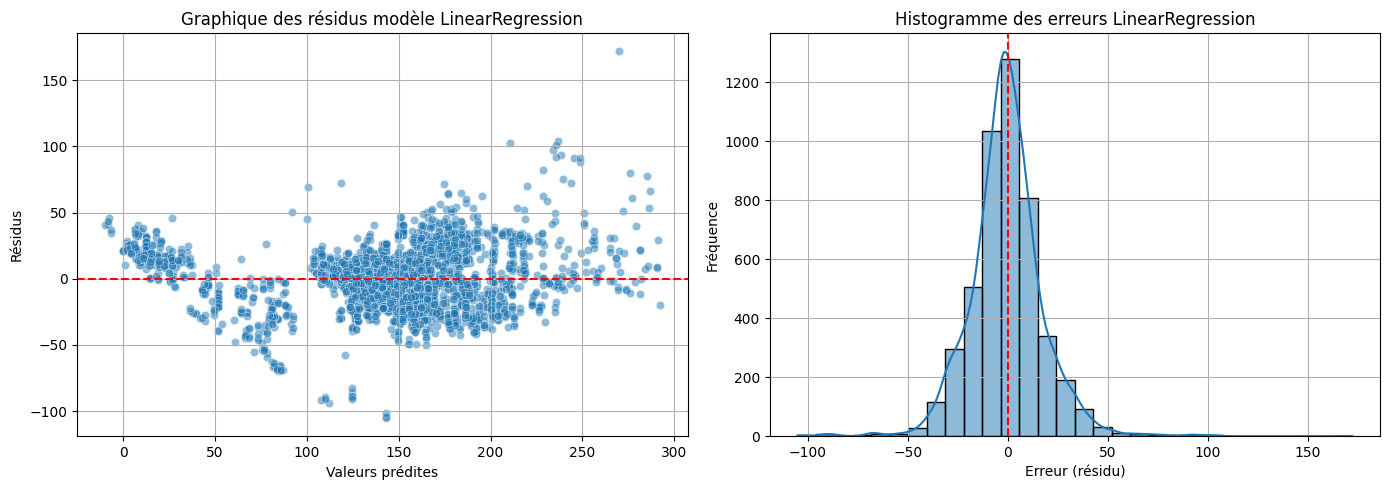

In [38]:
affichage_erreurs(y_test, predictions_lr, 'LinearRegression')

# Modèle Lasso

## Entrainement et optimisation

In [ ]:
# Grille des hyperparamètres à tester
param_grid_lasso = {
    'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'regressor__max_iter': [1000, 5000],
    'regressor__tol': [0.0001, 0.001],
}

best_model_lasso, best_params_lasso, predictions_lasso, resultats_lasso = entrainer_et_optimiser_model(Lasso(), param_grid_lasso, 'Lasso')
resultats_lr

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Le meilleur modèle a été sauvegardé sous le nom : Lasso_model.pkl
Meilleurs hyperparamètres : {'regressor__alpha': 0.0001, 'regressor__max_iter': 1000, 'regressor__tol': 0.0001}
Temps d'exécution : 39.56 secondes


Modèle  R² moyen (CV)  MAE moyen (CV)  RMSE train  MAE train  \
0  LinearRegression       0.999046        1.192338    1.654783   1.189319   

   R2 train  RMSE test  MAE test   R2 test  Ecart RMSE / MAE test  \
0  0.999066   1.703441  1.217518  0.999014               0.485924   

   Ratio overfitting  Alerte Underfitting  Temps d'exécution (s)  
0           0.000052                False                6.66649

### Comment détecter un surapprentissage ?


Comparer RMSE / MAE entre train et test.

Observer l’écart entre R² train et R² test :

Si R² train ≈ R² test ➡️ OK.

Si R² train très haut et R² test plus bas ➡️ ⚠️ Surapprentissage.

Calculer un ratio d’overfitting *r2_train - r2_test* : Plus ce ratio est élevé, plus il y a un risque de surapprentissage.

### Comment détecter le sous-apprentissage ?

R² faible sur le train (< 0.80)

RMSE / MAE élevés sur le train

Si R² train ≈ R² test, mais les deux sont bas

## Recharger un modèle

Pour recharger le modèle il suffira de :



```
# Charger le modèle enregistré
loaded_model = joblib.load('linear_regression_model.pkl')

# Prédire avec le modèle chargé
y_pred = loaded_model.predict(X_test)
```




## Comparaison des valeurs réelles et prédites

In [ ]:
pd.DataFrame({'Valeurs réelles': y_test.values.ravel(), 'Valeurs predict': predictions_lasso}).head(10)

Valeurs réelles  Valeurs predict
0              140       142.008070
1              117       116.531773
2              270       274.997022
3              138       141.051255
4              122       121.523475
5              138       139.506912
6               47        48.083721
7              131       132.208137
8              143       142.999765
9              125       126.576963

In [ ]:
affichage_valeurs_reelles_vs_predites_plotly(y_test, predictions_lasso, 'Lasso')

## Courbe d'apprentissage

### Objectif

La courbe d'apprentissage permet de vérifier si le modèle apprend bien avec plus de données.
<br/><p><b>Rappel :</b> </p>
<p><b>1. Courbe idéale (Bonne généralisation)</b></p>
<P>L’erreur d’entraînement diminue progressivement.</P>
<P>L’erreur de validation suit une trajectoire similaire.</P>
<P>Les deux erreurs se stabilisent à des valeurs proches.</P>
<p><b>2. Surajustement (Overfitting)</b></p>
<P>L’erreur d’entraînement est très faible (voire 0).</P>
<P>L’erreur de validation est élevée et ne diminue pas.</P>
<P>Le modèle a appris "par cœur" et ne généralise pas bien.</P>
<p><b>3. Sous-ajustement (Underfitting)</b></p>
<P>L’erreur d’entraînement et de validation restent élevées.</P>
<P>Le modèle est trop simple et n’arrive pas à capturer la relation entre X et y.</P>
<ul>
    <li>Si l'erreur de test est très supérieure à l'erreur d'entraînement → Sur-apprentissage.</li>
<li>Si l'erreur est élevée sur les deux courbes → Sous-apprentissage.</li>
</ul>

### Courbe

In [ ]:
afficher_courbes_apprentissage_plotly(best_model_lasso, 'Lasso')

## Affichage des erreurs de prédictions

### Objectif

La **courbe des résidus** permet de vérifier si les erreurs sont aléatoires ou s'il y a une tendance dans les erreurs du modèle.
<ul>
    <li>Bonne prédiction : les points doivent être répartis aléatoirement autour de 0.
</li>
<li>Mauvaise prédiction : structure visible (courbe, tendance…).</li>
</ul>

**L'histogramme des erreurs** permet de vérifier si les erreurs suivent une distribution normale.
<ul>
    <li>Bonne prédiction : la distribution est centrée sur 0 (forme de courbe en cloche).
</li>
<li>Mauvaise prédiction : la distribution asymétrique ou biaisée.</li>
</ul>

### Graphiques

In [ ]:
affichage_residus_plotly(y_test, predictions_lasso, 'Lasso')

In [ ]:
affichage_histogramme_erreurs_plotly(y_test, predictions_lasso, 'Lasso')

# Modèle Ridge

## Entrainement et optimisation

In [ ]:
# Grille des hyperparamètres à tester
param_grid_ridge = {
    'regressor__alpha': [0.1, 1, 10, 100],
}

best_model_ridge, best_params_ridge, predictions_ridge, resultats_ridge = entrainer_et_optimiser_model(Ridge(), param_grid_ridge, 'Ridge')
resultats_ridge

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Le meilleur modèle a été sauvegardé sous le nom : Ridge_model.pkl
Meilleurs hyperparamètres : {'regressor__alpha': 0.1}
Temps d'exécution : 4.22 secondes


Modèle  R² moyen (CV)  MAE moyen (CV)  RMSE train  MAE train  R2 train  \
0  Ridge       0.999047         1.21481    1.668521   1.189953   0.99905   

   RMSE test  MAE test   R2 test  Ecart RMSE / MAE test  Ratio overfitting  \
0   1.700085  1.215827  0.999018               0.484258           0.000033   

   Alerte Underfitting  Temps d'exécution (s)  
0                False               4.216608

### Comment détecter un surapprentissage ?


Comparer RMSE / MAE entre train et test.

Observer l’écart entre R² train et R² test :

Si R² train ≈ R² test ➡️ OK.

Si R² train très haut et R² test plus bas ➡️ ⚠️ Surapprentissage.

Calculer un ratio d’overfitting *r2_train - r2_test* : Plus ce ratio est élevé, plus il y a un risque de surapprentissage.

### Comment détecter le sous-apprentissage ?

R² faible sur le train (< 0.80)

RMSE / MAE élevés sur le train

Si R² train ≈ R² test, mais les deux sont bas

## Recharger un modèle

Pour recharger le modèle il suffira de :



```
# Charger le modèle enregistré
loaded_model = joblib.load('linear_regression_model.pkl')

# Prédire avec le modèle chargé
y_pred = loaded_model.predict(X_test)
```




## Comparaison des valeurs réelles et prédites

In [ ]:
pd.DataFrame({'Valeurs réelles': y_test.values.ravel(), 'Valeurs predict': predictions_ridge}).head(10)

Valeurs réelles  Valeurs predict
0              140       142.009804
1              117       116.573254
2              270       274.987578
3              138       141.089809
4              122       121.471663
5              138       139.496513
6               47        48.008779
7              131       132.200122
8              143       142.988495
9              125       126.559674

In [ ]:
affichage_valeurs_reelles_vs_predites_plotly(y_test, predictions_ridge, 'Ridge')

## Courbe d'apprentissage

### Objectif

La courbe d'apprentissage permet de vérifier si le modèle apprend bien avec plus de données.
<br/><p><b>Rappel :</b> </p>
<p><b>1. Courbe idéale (Bonne généralisation)</b></p>
<P>L’erreur d’entraînement diminue progressivement.</P>
<P>L’erreur de validation suit une trajectoire similaire.</P>
<P>Les deux erreurs se stabilisent à des valeurs proches.</P>
<p><b>2. Surajustement (Overfitting)</b></p>
<P>L’erreur d’entraînement est très faible (voire 0).</P>
<P>L’erreur de validation est élevée et ne diminue pas.</P>
<P>Le modèle a appris "par cœur" et ne généralise pas bien.</P>
<p><b>3. Sous-ajustement (Underfitting)</b></p>
<P>L’erreur d’entraînement et de validation restent élevées.</P>
<P>Le modèle est trop simple et n’arrive pas à capturer la relation entre X et y.</P>
<ul>
    <li>Si l'erreur de test est très supérieure à l'erreur d'entraînement → Sur-apprentissage.</li>
<li>Si l'erreur est élevée sur les deux courbes → Sous-apprentissage.</li>
</ul>

### Courbe

In [ ]:
afficher_courbes_apprentissage_plotly(best_model_ridge, 'Ridge')

## Affichage des erreurs de prédictions

### Objectif

La **courbe des résidus** permet de vérifier si les erreurs sont aléatoires ou s'il y a une tendance dans les erreurs du modèle.
<ul>
    <li>Bonne prédiction : les points doivent être répartis aléatoirement autour de 0.
</li>
<li>Mauvaise prédiction : structure visible (courbe, tendance…).</li>
</ul>

**L'histogramme des erreurs** permet de vérifier si les erreurs suivent une distribution normale.
<ul>
    <li>Bonne prédiction : la distribution est centrée sur 0 (forme de courbe en cloche).
</li>
<li>Mauvaise prédiction : la distribution asymétrique ou biaisée.</li>
</ul>

### Graphiques

In [ ]:
affichage_residus_plotly(y_test, predictions_ridge, 'Ridge')

In [ ]:
affichage_histogramme_erreurs_plotly(y_test, predictions_ridge, 'Ridge')

# Modèle SGDRegressor

## Entrainement et optimisation

In [ ]:
# Grille des hyperparamètres à tester
param_grid_sgdr = {
    'regressor__alpha': [0.001, 0.01],
    'regressor__penalty': ['l1', 'l2', 'elasticnet'],
    'regressor__l1_ratio': [0.15, 0.5]
}

best_model_sgdr, best_params_sgdr, predictions_sgdr, resultats_sgdr = entrainer_et_optimiser_model(SGDRegressor(), param_grid_sgdr, 'SGDRegressor')
resultats_sgdr

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Le meilleur modèle a été sauvegardé sous le nom : SGDRegressor_model.pkl
Meilleurs hyperparamètres : {'regressor__alpha': 0.001, 'regressor__l1_ratio': 0.15, 'regressor__penalty': 'l1'}
Temps d'exécution : 162.50 secondes


Modèle  R² moyen (CV)  MAE moyen (CV)  RMSE train  MAE train  \
0  SGDRegressor       0.999005        1.568862    1.702048   1.204853   

   R2 train  RMSE test  MAE test   R2 test  Ecart RMSE / MAE test  \
0  0.999012   1.736784   1.22996  0.998975               0.506824   

   Ratio overfitting  Alerte Underfitting  Temps d'exécution (s)  
0           0.000037                False             162.499417

## Comparaison des valeurs réelles et prédites

In [ ]:
pd.DataFrame({'Valeurs réelles': y_test.values.ravel(), 'Valeurs predict': predictions_sgdr}).head(10)

Valeurs réelles  Valeurs predict
0              140       141.890339
1              117       116.424595
2              270       274.846640
3              138       141.047299
4              122       121.486391
5              138       139.446691
6               47        48.182559
7              131       132.212721
8              143       142.891939
9              125       126.502092

In [ ]:
affichage_valeurs_reelles_vs_predites_plotly(y_test, predictions_sgdr, 'SGDRegressor')

## Courbe d'apprentissage

### Objectif

La courbe d'apprentissage permet de vérifier si le modèle apprend bien avec plus de données.
<br/><p><b>Rappel :</b> </p>
<p><b>1. Courbe idéale (Bonne généralisation)</b></p>
<P>L’erreur d’entraînement diminue progressivement.</P>
<P>L’erreur de validation suit une trajectoire similaire.</P>
<P>Les deux erreurs se stabilisent à des valeurs proches.</P>
<p><b>2. Surajustement (Overfitting)</b></p>
<P>L’erreur d’entraînement est très faible (voire 0).</P>
<P>L’erreur de validation est élevée et ne diminue pas.</P>
<P>Le modèle a appris "par cœur" et ne généralise pas bien.</P>
<p><b>3. Sous-ajustement (Underfitting)</b></p>
<P>L’erreur d’entraînement et de validation restent élevées.</P>
<P>Le modèle est trop simple et n’arrive pas à capturer la relation entre X et y.</P>
<ul>
    <li>Si l'erreur de test est très supérieure à l'erreur d'entraînement → Sur-apprentissage.</li>
<li>Si l'erreur est élevée sur les deux courbes → Sous-apprentissage.</li>
</ul>

### Courbe

In [ ]:
afficher_courbes_apprentissage_plotly(best_model_sgdr, 'SGDRegressor')

L’erreur de validation chute fortement entre 5k et 20k données.

Ensuite, les gains sont faibles → le modèle semble atteindre un plateau.

## Affichage des erreurs de prédictions

### Objectif

La **courbe des résidus** permet de vérifier si les erreurs sont aléatoires ou s'il y a une tendance dans les erreurs du modèle.
<ul>
    <li>Bonne prédiction : les points doivent être répartis aléatoirement autour de 0.
</li>
<li>Mauvaise prédiction : structure visible (courbe, tendance…).</li>
</ul>

**L'histogramme des erreurs** permet de vérifier si les erreurs suivent une distribution normale.
<ul>
    <li>Bonne prédiction : la distribution est centrée sur 0 (forme de courbe en cloche).
</li>
<li>Mauvaise prédiction : la distribution asymétrique ou biaisée.</li>
</ul>

### Graphiques

In [ ]:
affichage_residus_plotly(y_test, predictions_sgdr, 'SGDRegressor')

In [ ]:
affichage_histogramme_erreurs_plotly(y_test, predictions_sgdr, 'SGDRegressor')

# Modèle RandomForestRegressor

## Entrainement et optimisation

In [ ]:
# Grille des hyperparamètres à tester
param_grid_rfr = {
    'regressor__n_estimators': [100, 200],   # Supprimer 300
    'regressor__max_features': ['sqrt'],     # Garder seulement 'sqrt'
    'regressor__max_depth': [30]             # Tester juste 30
}

best_model_rfr, best_params_rfr, predictions_rfr, resultats_rfr = entrainer_et_optimiser_model(RandomForestRegressor(), param_grid_rfr, 'RandomForestRegressor', cv=2, method='RandomizedSearchCV')
resultats_rfr

Fitting 2 folds for each of 2 candidates, totalling 4 fits
Le meilleur modèle a été sauvegardé sous le nom : RandomForestRegressor_model.pkl
Meilleurs hyperparamètres : {'regressor__n_estimators': 200, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 30}
Temps d'exécution : 555.89 secondes


Modèle  R² moyen (CV)  MAE moyen (CV)  RMSE train  \
0  RandomForestRegressor       0.999276        0.633731    0.564897   

   MAE train  R2 train  RMSE test  MAE test   R2 test  Ecart RMSE / MAE test  \
0   0.303855  0.999891   1.338243  0.584767  0.999391               0.753476   

   Ratio overfitting  Alerte Underfitting  Temps d'exécution (s)  
0             0.0005                False             555.886643

## Comparaison des valeurs réelles et prédites

In [ ]:
pd.DataFrame({'Valeurs réelles': y_test.values.ravel(), 'Valeurs predict': predictions_rfr}).head(10)

Valeurs réelles  Valeurs predict
0              140       142.118322
1              117       117.766841
2              270       268.865000
3              138       137.687784
4              122       123.969618
5              138       138.325739
6               47        46.710417
7              131       131.598914
8              143       140.619048
9              125       125.664340

In [ ]:
affichage_valeurs_reelles_vs_predites_plotly(y_test, predictions_rfr, 'RandomForestRegressor')

## Importance des variables (courbe d'apprentissage trop longue)

In [ ]:
# Récupérer le préprocessing depuis le meilleur modèle
preprocessor = best_model_rfr.named_steps['preprocessing']

# Noms des features après transformation
feature_names = preprocessor.get_feature_names_out()

# # Vérifier que les tailles correspondent
# print(len(feature_names), len(best_model_rfr.named_steps['regressor'].feature_importances_))


In [ ]:
importances = best_model_rfr.named_steps['regressor'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False).head(10)


In [ ]:
fig = px.bar(
    importance_df,
    x='Importance',
    y='Feature',
    orientation='h',
    title="Importance des variables"
)
fig.show()


## Affichage des erreurs de prédictions

### Graphiques

In [ ]:
affichage_residus_plotly(y_test, predictions_rfr, 'RandomForestRegressor')

In [ ]:
affichage_histogramme_erreurs_plotly(y_test, predictions_rfr, 'RandomForestRegressor')

In [ ]:
# Calcul des résidus (erreurs)
residus = y_test - predictions_rfr

# Ajout dans un DataFrame pour analyse
import pandas as pd
resultats_erreurs = pd.DataFrame({
    'Réel': y_test,
    'Prédiction': predictions_rfr,
    'Résidu': residus
})


In [ ]:
# Tri décroissant des erreurs absolues
resultats_erreurs['Erreur_absolue'] = resultats_erreurs['Résidu'].abs()
top_erreurs = resultats_erreurs.sort_values(by='Erreur_absolue', ascending=False).head(10)
top_erreurs


Réel  Prédiction     Résidu  Erreur_absolue
80892   312  234.570000  77.430000       77.430000
60201   300  248.495000  51.505000       51.505000
28419   456  406.965000  49.035000       49.035000
15990   393  344.705000  48.295000       48.295000
34530   304  335.945000 -31.945000       31.945000
70745   300  327.170000 -27.170000       27.170000
5474    385  358.150000  26.850000       26.850000
9707    377  351.638333  25.361667       25.361667
4156    156  133.898555  22.101445       22.101445
37040   267  245.335000  21.665000       21.665000

In [ ]:
# Index des plus grosses erreurs
index_erreurs = top_erreurs.index

# Récupération des lignes concernées dans X_test
X_test.loc[index_erreurs]


Marque Carburant  Cylindrée moteur  Puissance moteur  \
80892          INEOS    diesel            2993.0             183.0   
60201       MASERATI    petrol            2979.0             257.0   
28419  MERCEDES BENZ    petrol            3982.0             430.0   
15990        FERRARI    petrol            6496.0             529.0   
34530  MERCEDES BENZ    petrol            3982.0             410.0   
70745  MERCEDES BENZ    petrol            3982.0             410.0   
5474         FERRARI    petrol            6496.0             607.0   
9707       CHEVROLET    petrol            5460.0             475.0   
4156            FIAT    petrol             875.0              62.0   
37040     ALFA ROMEO    petrol            2891.0             375.0   

       Consommation carburant  Masse moyenne       Gamme  
80892                    12.2         2948.5   Dynamique  
60201                    13.3         2289.5    Sportive  
28419                    20.1         3008.0        Luxe  
15990                    17.3         2333.5        Luxe  
34530                    13.4         2897.0        Luxe  
70745                    13.2         2861.5        Luxe  
5474                     16.9         1793.0        Luxe  
9707                     16.5         1862.0        Luxe  
4156                      6.9         1222.0  Economique  
37040                    11.8         2030.0    Sportive

# Modèle DecisionTreeRegressor

## Entrainement et optimisation

In [ ]:
# Grille des hyperparamètres à tester
# param_grid_dtr = {
#     'regressor__criterion': ['squared_error', 'absolute_error'],
#     'regressor__max_depth': [5, 10, 20, None],
#     'regressor__min_samples_split': [2, 5, 10],
#     'regressor__min_samples_leaf': [1, 2, 5],
#     'regressor__max_features': [None, 'sqrt', 'log2']
# }
param_grid_dtr = {
    'regressor__max_depth': [10, 20, 30],
    'regressor__min_samples_leaf': [5, 10, 20]
}

best_model_dtr, best_params_dtr, predictions_dtr, resultats_dtr = entrainer_et_optimiser_model(DecisionTreeRegressor(random_state=24), param_grid_dtr, 'DecisionTreeRegressor', cv=3, method='Random')
resultats_dtr

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Le meilleur modèle a été sauvegardé sous le nom : DecisionTreeRegressor_model.pkl
Meilleurs hyperparamètres : {'regressor__min_samples_leaf': 5, 'regressor__max_depth': 30}
Temps d'exécution : 19.38 secondes


Modèle  R² moyen (CV)  MAE moyen (CV)  RMSE train  \
0  DecisionTreeRegressor       0.999487        0.637941    0.901297   

   MAE train  R2 train  RMSE test  MAE test   R2 test  Ecart RMSE / MAE test  \
0   0.385979  0.999723   1.286601  0.543567  0.999437               0.743034   

   Ratio overfitting  Alerte Underfitting  Temps d'exécution (s)  
0           0.000285                False              19.384689

## Recharger un modèle

Pour recharger le modèle il suffira de :



```
# Charger le modèle enregistré
loaded_model = joblib.load('linear_regression_model.pkl')

# Prédire avec le modèle chargé
y_pred = loaded_model.predict(X_test)
```




## Comparaison des valeurs réelles et prédites

In [ ]:
pd.DataFrame({'Valeurs réelles': y_test.values.ravel(), 'Valeurs predict': predictions_dtr}).head(10)

Valeurs réelles  Valeurs predict
0              140       142.222222
1              117       118.142857
2              270       269.400000
3              138       138.000000
4              122       121.833333
5              138       138.000000
6               47        47.000000
7              131       131.400000
8              143       141.571429
9              125       125.625000

In [ ]:
affichage_valeurs_reelles_vs_predites_plotly(y_test, predictions_dtr, 'DecisionTreeRegressor')

## Courbe d'apprentissage

### Objectif

La courbe d'apprentissage permet de vérifier si le modèle apprend bien avec plus de données.
<br/><p><b>Rappel :</b> </p>
<p><b>1. Courbe idéale (Bonne généralisation)</b></p>
<P>L’erreur d’entraînement diminue progressivement.</P>
<P>L’erreur de validation suit une trajectoire similaire.</P>
<P>Les deux erreurs se stabilisent à des valeurs proches.</P>
<p><b>2. Surajustement (Overfitting)</b></p>
<P>L’erreur d’entraînement est très faible (voire 0).</P>
<P>L’erreur de validation est élevée et ne diminue pas.</P>
<P>Le modèle a appris "par cœur" et ne généralise pas bien.</P>
<p><b>3. Sous-ajustement (Underfitting)</b></p>
<P>L’erreur d’entraînement et de validation restent élevées.</P>
<P>Le modèle est trop simple et n’arrive pas à capturer la relation entre X et y.</P>
<ul>
    <li>Si l'erreur de test est très supérieure à l'erreur d'entraînement → Sur-apprentissage.</li>
<li>Si l'erreur est élevée sur les deux courbes → Sous-apprentissage.</li>
</ul>

### Courbe

In [ ]:
afficher_courbes_apprentissage_plotly(best_model_dtr, 'DecisionTreeRegressor')

## Affichage des erreurs de prédictions

### Objectif

La **courbe des résidus** permet de vérifier si les erreurs sont aléatoires ou s'il y a une tendance dans les erreurs du modèle.
<ul>
    <li>Bonne prédiction : les points doivent être répartis aléatoirement autour de 0.
</li>
<li>Mauvaise prédiction : structure visible (courbe, tendance…).</li>
</ul>

**L'histogramme des erreurs** permet de vérifier si les erreurs suivent une distribution normale.
<ul>
    <li>Bonne prédiction : la distribution est centrée sur 0 (forme de courbe en cloche).
</li>
<li>Mauvaise prédiction : la distribution asymétrique ou biaisée.</li>
</ul>

### Graphiques

In [ ]:
affichage_residus_plotly(y_test, predictions_dtr, 'DecisionTreeRegressor')

In [ ]:
affichage_histogramme_erreurs_plotly(y_test, predictions_dtr, 'DecisionTreeRegressor')

# Modèle GradientBoostingRegressor

## Entrainement et optimisation

In [ ]:
# Grille des hyperparamètres à tester
# param_grid_gb = {
#     'regressor__n_estimators': [100, 200],    # Nombre d'arbres
#     'regressor__learning_rate': [0.05, 0.1], # Taux d'apprentissage
#     'regressor__max_depth': [3, 5],          # Profondeur maximale des arbres
#     'regressor__min_samples_leaf': [1, 5]    # Nombre minimal d'échantillons par feuille
# }

param_grid_gb = {
    'regressor__n_estimators': [100],
    'regressor__learning_rate': [0.1],
    'regressor__max_depth': [3],
}

best_model_gb, best_params_gb, predictions_gb, resultats_gb = entrainer_et_optimiser_model(
    GradientBoostingRegressor(random_state=42),
    param_grid_gb,
    'GradientBoostingRegressor'
)

# Affichage des résultats
resultats_gb

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Le meilleur modèle a été sauvegardé sous le nom : GradientBoostingRegressor_model.pkl
Meilleurs hyperparamètres : {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}
Temps d'exécution : 36.27 secondes


Modèle  R² moyen (CV)  MAE moyen (CV)  RMSE train  \
0  GradientBoostingRegressor       0.998644        1.345178    1.769919   

   MAE train  R2 train  RMSE test  MAE test   R2 test  Ecart RMSE / MAE test  \
0   1.268823  0.998931   1.789111  1.287205  0.998912               0.501906   

   Ratio overfitting  Alerte Underfitting  Temps d'exécution (s)  
0           0.000019                False              36.267723

## Recharger un modèle

Pour recharger le modèle il suffira de :



```
# Charger le modèle enregistré
loaded_model = joblib.load('linear_regression_model.pkl')

# Prédire avec le modèle chargé
y_pred = loaded_model.predict(X_test)
```




## Comparaison des valeurs réelles et prédites

In [ ]:
pd.DataFrame({'Valeurs réelles': y_test.values.ravel(), 'Valeurs predict': predictions_gb}).head(10)

Valeurs réelles  Valeurs predict
0              140       142.130330
1              117       118.439750
2              270       268.982961
3              138       139.797766
4              122       122.684836
5              138       139.546747
6               47        48.582158
7              131       132.361387
8              143       139.634987
9              125       128.726942

In [ ]:
affichage_valeurs_reelles_vs_predites_plotly(y_test, predictions_gb, 'GradientBoostingRegressor')

## Courbe d'apprentissage

### Objectif

La courbe d'apprentissage permet de vérifier si le modèle apprend bien avec plus de données.
<br/><p><b>Rappel :</b> </p>
<p><b>1. Courbe idéale (Bonne généralisation)</b></p>
<P>L’erreur d’entraînement diminue progressivement.</P>
<P>L’erreur de validation suit une trajectoire similaire.</P>
<P>Les deux erreurs se stabilisent à des valeurs proches.</P>
<p><b>2. Surajustement (Overfitting)</b></p>
<P>L’erreur d’entraînement est très faible (voire 0).</P>
<P>L’erreur de validation est élevée et ne diminue pas.</P>
<P>Le modèle a appris "par cœur" et ne généralise pas bien.</P>
<p><b>3. Sous-ajustement (Underfitting)</b></p>
<P>L’erreur d’entraînement et de validation restent élevées.</P>
<P>Le modèle est trop simple et n’arrive pas à capturer la relation entre X et y.</P>
<ul>
    <li>Si l'erreur de test est très supérieure à l'erreur d'entraînement → Sur-apprentissage.</li>
<li>Si l'erreur est élevée sur les deux courbes → Sous-apprentissage.</li>
</ul>

### Courbe

In [ ]:
afficher_courbes_apprentissage_plotly(best_model_gb, 'GradientBoostingRegressor')

## Affichage des erreurs de prédictions

### Objectif

La **courbe des résidus** permet de vérifier si les erreurs sont aléatoires ou s'il y a une tendance dans les erreurs du modèle.
<ul>
    <li>Bonne prédiction : les points doivent être répartis aléatoirement autour de 0.
</li>
<li>Mauvaise prédiction : structure visible (courbe, tendance…).</li>
</ul>

**L'histogramme des erreurs** permet de vérifier si les erreurs suivent une distribution normale.
<ul>
    <li>Bonne prédiction : la distribution est centrée sur 0 (forme de courbe en cloche).
</li>
<li>Mauvaise prédiction : la distribution asymétrique ou biaisée.</li>
</ul>

### Graphiques

In [ ]:
affichage_residus_plotly(y_test, predictions_gb, 'GradientBoostingRegressor')

In [ ]:
affichage_histogramme_erreurs_plotly(y_test, predictions_gb, 'GradientBoostingRegressor')

# Modèle XGBoostRegressor

## Entrainement et optimisation

In [39]:
# Grille des hyperparamètres à tester
# param_grid_gb = {
#     'regressor__n_estimators': [100, 200],    # Nombre d'arbres
#     'regressor__learning_rate': [0.05, 0.1], # Taux d'apprentissage
#     'regressor__max_depth': [3, 5],          # Profondeur maximale des arbres
#     'regressor__min_samples_leaf': [1, 5]    # Nombre minimal d'échantillons par feuille
# }

param_grid_xgb = {
    'regressor__n_estimators': [100, 300],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5],
    'regressor__subsample': [0.8, 1.0]  # Pour contrôler le surapprentissage
}


best_model_xgb, best_params_xgb, predictions_xgb, resultats_xgb = entrainer_et_optimiser_model(
    XGBRegressor(random_state=42, n_jobs=-1, verbosity=1),
    param_grid_xgb,
    'XGBoost'
)

# Affichage des résultats
resultats_xgb

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Le meilleur modèle a été sauvegardé sous le nom : XGBoost_model.pkl
Meilleurs hyperparamètres : {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 300, 'regressor__subsample': 1.0}
Temps d'exécution : 28.41 secondes


Modèle  R² moyen (CV)  MAE moyen (CV)  RMSE train  MAE train  R2 train  \
0  XGBoost       0.980105        6.852269    6.004209   4.564737  0.984795   

   RMSE test  MAE test   R2 test  Ecart RMSE / MAE test  Ratio overfitting  \
0   6.673932  4.977802  0.980238                1.69613           0.004556   

   Alerte Underfitting  Temps d'exécution (s)  
0                False              28.409653

## Recharger un modèle

Pour recharger le modèle il suffira de :



```
# Charger le modèle enregistré
loaded_model = joblib.load('linear_regression_model.pkl')

# Prédire avec le modèle chargé
y_pred = loaded_model.predict(X_test)
```




## Comparaison des valeurs réelles et prédites

In [40]:
pd.DataFrame({'Valeurs réelles': y_test.values.ravel(), 'Valeurs predict': predictions_xgb}).head(10)

Valeurs réelles  Valeurs predict
0              182       182.058258
1              151       146.238617
2              171       156.499435
3              123       124.786644
4              133       131.265533
5              148       145.100403
6              134       131.265533
7              136       135.515305
8              133       135.062439
9              123       130.242783

In [ ]:
affichage_valeurs_reelles_vs_predites_plotly(y_test, predictions_xgb, 'XGBoostRegressor')

## Courbe d'apprentissage

### Objectif

La courbe d'apprentissage permet de vérifier si le modèle apprend bien avec plus de données.
<br/><p><b>Rappel :</b> </p>
<p><b>1. Courbe idéale (Bonne généralisation)</b></p>
<P>L’erreur d’entraînement diminue progressivement.</P>
<P>L’erreur de validation suit une trajectoire similaire.</P>
<P>Les deux erreurs se stabilisent à des valeurs proches.</P>
<p><b>2. Surajustement (Overfitting)</b></p>
<P>L’erreur d’entraînement est très faible (voire 0).</P>
<P>L’erreur de validation est élevée et ne diminue pas.</P>
<P>Le modèle a appris "par cœur" et ne généralise pas bien.</P>
<p><b>3. Sous-ajustement (Underfitting)</b></p>
<P>L’erreur d’entraînement et de validation restent élevées.</P>
<P>Le modèle est trop simple et n’arrive pas à capturer la relation entre X et y.</P>
<ul>
    <li>Si l'erreur de test est très supérieure à l'erreur d'entraînement → Sur-apprentissage.</li>
<li>Si l'erreur est élevée sur les deux courbes → Sous-apprentissage.</li>
</ul>

### Courbe

In [41]:
afficher_courbes_apprentissage_plotly(best_model_xgb, 'XGBoostRegressor')

## Affichage des erreurs de prédictions

### Objectif

La **courbe des résidus** permet de vérifier si les erreurs sont aléatoires ou s'il y a une tendance dans les erreurs du modèle.
<ul>
    <li>Bonne prédiction : les points doivent être répartis aléatoirement autour de 0.
</li>
<li>Mauvaise prédiction : structure visible (courbe, tendance…).</li>
</ul>

**L'histogramme des erreurs** permet de vérifier si les erreurs suivent une distribution normale.
<ul>
    <li>Bonne prédiction : la distribution est centrée sur 0 (forme de courbe en cloche).
</li>
<li>Mauvaise prédiction : la distribution asymétrique ou biaisée.</li>
</ul>

### Graphiques

In [42]:
affichage_residus_plotly(y_test, predictions_xgb, 'XGBoostRegressor')

In [43]:
affichage_histogramme_erreurs_plotly(y_test, predictions_xgb, 'XGBoostRegressor')

# Conclusion

In [45]:
# Concaténation des résultats
# resultats_concat = pd.concat([resultats_lr, resultats_lasso, resultats_ridge, resultats_sgdr, resultats_rfr, resultats_dtr, resultats_gb, resultats_xgb], ignore_index=True)
# resultats_concat

resultats_concat = pd.concat([resultats_lr, resultats_xgb], ignore_index=True)
resultats_concat

Modèle  R² moyen (CV)  MAE moyen (CV)  RMSE train  MAE train  \
0  LinearRegression       0.861633       12.755799   18.092005  12.746382   
1           XGBoost       0.980105        6.852269    6.004209   4.564737   

   R2 train  RMSE test   MAE test   R2 test  Ecart RMSE / MAE test  \
0  0.861944  18.333669  13.053282  0.850873               5.280387   
1  0.984795   6.673932   4.977802  0.980238               1.696130   

   Ratio overfitting  Alerte Underfitting  Temps d'exécution (s)  
0           0.011071                False               3.104545  
1           0.004556                False              28.409653

RMSE LR test: 1.703441 → L'erreur moyenne de prédiction est d'environ 1.703441 g/km.

In [46]:
# Tri du DataFrame par R² test décroissant
resultats_concat_sorted = resultats_concat.sort_values(by='R2 test', ascending=False)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=resultats_concat_sorted['Modèle'],
    y=resultats_concat_sorted['R2 test'],
    name='R2 Test',
    text=resultats_concat_sorted['R2 test'].round(6),
    textposition='outside'
))

fig.update_layout(
    title='Comparaison des scores R2 test par modèle',
    xaxis_title='Modèle',
    yaxis_title='R2 Test',
    height=600,
    width=1000
)

fig.show()


In [47]:
resultats_concat_sorted = resultats_concat.sort_values(by='RMSE test', ascending=False)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=resultats_concat_sorted['Modèle'],
    y=resultats_concat_sorted['RMSE test'],
    name='RMSE test',
    text=resultats_concat_sorted['RMSE test'].round(6),
    textposition='outside'
))

fig.update_layout(
    title='Comparaison des RMSE test par modèle',
    xaxis_title='Modèle',
    yaxis_title='RMSE Test',
    height=600,
    width=1000
)

fig.show()

In [48]:
resultats_concat_sorted = resultats_concat.sort_values(by='MAE test', ascending=False)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=resultats_concat_sorted['Modèle'],
    y=resultats_concat_sorted['MAE test'],
    name='MAE test',
    text=resultats_concat_sorted['MAE test'].round(6),
    textposition='outside'
))

fig.update_layout(
    title='Comparaison des MAE test par modèle',
    xaxis_title='Modèle',
    yaxis_title='MAE Test',
    height=600,
    width=1000
)

fig.show()

In [49]:
resultats_concat = resultats_concat.sort_values(by="Ecart RMSE / MAE test", ascending=False)

# Création du graphique avec dégradé de couleur
fig = px.bar(
    resultats_concat,
    x='Modèle',
    y="Ecart RMSE / MAE test",
    text=resultats_concat["Ecart RMSE / MAE test"].round(2),
    color="Ecart RMSE / MAE test",
    color_continuous_scale='RdYlGn_r',
    title="Ecart RMSE / MAE test"
)

# Personnalisation
fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_title='Modèle',
    yaxis_title='Ecart RMSE / MAE test',
    height=600,
    width=1000,
    coloraxis_colorbar=dict(
        title="Ecart RMSE / MAE test"
    )
)

fig.show()


Plus l’écart RMSE - MAE est grand plus il y a des grosses erreurs isolées dans ce modèle (sensibilité de RMSE aux outliers).

Si l’écart est faible, ça veut dire que les erreurs sont assez homogènes.

In [50]:
resultats_concat = resultats_concat.sort_values(by="Temps d'exécution (s)", ascending=False)

# Création du graphique avec dégradé de couleur
fig = px.bar(
    resultats_concat,
    x='Modèle',
    y="Temps d'exécution (s)",
    text=resultats_concat["Temps d'exécution (s)"].round(2),
    color="Temps d'exécution (s)",
    color_continuous_scale='RdYlGn_r',
    title="Temps d'exécution des modèles"
)

# Personnalisation
fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_title='Modèle',
    yaxis_title='Temps d\'exécution (s)',
    height=600,
    width=1000,
    coloraxis_colorbar=dict(
        title="Temps (s)"
    )
)

fig.show()


Comment choisir ?
🔹 1️⃣ Meilleur R² test (qualité globale) :
✅ XGBoost (0.999762)

🔹 2️⃣ Plus petite MAE test (erreur moyenne) :
✅ DecisionTreeRegressor (0.547811)

🔹 3️⃣ Plus petit RMSE test (erreur quadratique) :
✅ XGBoost (0.836187)

🔹 4️⃣ Temps de calcul :
Si le temps est critique → DecisionTreeRegressor (14.5 s).
Sinon, XGBoost reste rapide et efficace (78 s).

Moi je partirais sur XGBoost :

Meilleur score global :

A le R² test le plus élevé (0.999762) (ça veut dire qu'il explique 99.9762 % de la variance de la cible).

A une MAE test et RMSE test très basses, proches du meilleur.

A un écart train/test faible (peu de surapprentissage).

Et reste raisonnable en temps de calcul.

Stable.

Bon temps d'exécution.

Moins sensible au surapprentissage que l'arbre seul.

# Exemple de prédiction


```
# Path to the saved model
model_path = dossier_modeles + f"LinearRegression_model.pkl"
loaded_model = joblib.load(model_path)

# Example New Data Input
new_data = pd.DataFrame({
    "Masse à vide": [1845],
    "Carburant": ["hybride"],
    "Cylindrée moteur": [1332],
    "Puissance moteur": [96],
    "Consommation carburant": [2]
})

# Predict CO2 Emissions
prediction = loaded_model.predict(new_data)
print("\n🚀 CO2 Emissions Prediction for New Input Data:")
print(f"Predicted CO2 Emissions: {prediction[0]:.2f} g/km")
```



# Commentés

In [ ]:
# # Colonnes à transformer
# # Colonnes catégorielles
# categorical_features = ['Marque', 'Carburant', 'Gamme']
# # Colonnes numériques
# numeric_features = X.drop(columns=categorical_features).columns.tolist()

# # Préprocesseur pour le pipeline
# preprocessor = ColumnTransformer([
#     ('num', StandardScaler(), numeric_features),
#     ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
# ])

# # Pipeline complet
# pipeline = Pipeline([
#     ('preprocessing', preprocessor),
#     ('regressor', SGDRegressor(random_state=0, max_iter=1000))
# ])

# # Grille des hyperparamètres
# param_grid = {
#     'regressor__alpha': [0.001, 0.01],
#     'regressor__penalty': ['l1', 'l2', 'elasticnet'],
#     'regressor__l1_ratio': [0.15, 0.5],
#     'selector__threshold': ['mean', 'median']
# }

# # GridSearchCV
# grid_search = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     scoring='r2',
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

# # Entraînement du pipeline
# grid_search.fit(X_train, y_train)

# # Résultats
# print(f"\n✅ Meilleur score R² CV : {grid_search.best_score_:.4f}")
# print(f"🏅 Meilleurs hyperparamètres : {grid_search.best_params_}")

# # Test final
# y_pred = grid_search.best_estimator_.predict(X_test)
# r2 = r2_score(y_test, y_pred)
# print(f"🎯 R² final sur le test : {r2:.4f}")


In [ ]:
# fig = go.Figure()

# fig.add_trace(go.Bar(
#     x=resultats_concat['Modèle'],
#     y=resultats_concat['RMSE train'],
#     name='RMSE Train',
#     text=resultats_concat['RMSE train'].round(6),  # Affichage des valeurs arrondies
#     textposition='outside'
# ))

# fig.add_trace(go.Bar(
#     x=resultats_concat['Modèle'],
#     y=resultats_concat['RMSE test'],
#     name='RMSE Test',
#     text=resultats_concat['RMSE test'].round(6),  # Affichage des valeurs arrondies
#     textposition='outside'
# ))

# # Personnalisation
# fig.update_layout(
#     title='Comparaison des RMSE par modèle',
#     xaxis_title='Modèle',
#     yaxis_title='RMSE',
#     barmode='group',
#     height=600,
#     width=1000
# )

# fig.show()
# #

In [ ]:
# fig = go.Figure()

# fig.add_trace(go.Bar(
#     x=resultats_concat['Modèle'],
#     y=resultats_concat['MAE train'],
#     name='MAE Train',
#     text=resultats_concat['MAE train'].round(6),  # Affichage des valeurs arrondies
#     textposition='outside'
# ))

# fig.add_trace(go.Bar(
#     x=resultats_concat['Modèle'],
#     y=resultats_concat['MAE test'],
#     name='MAE Test',
#     text=resultats_concat['MAE test'].round(6),  # Affichage des valeurs arrondies
#     textposition='outside'
# ))

# # Personnalisation
# fig.update_layout(
#     title='Comparaison des MAE par modèle',
#     xaxis_title='Modèle',
#     yaxis_title='MAE',
#     barmode='group',
#     height=600,
#     width=1000
# )

# fig.show()
